In [1]:
import numpy as np
import scipy
import scipy.io
import matplotlib.pyplot as plt
import copy,sys,os,pdb,importlib
from importlib import reload
import pandas as pd
import seaborn as sns

sys.path.append('../../')
sys.path.append('../../util_code')
import util_code
# from util_code import place_cell_analysis as pa
import place_cell_analysis as pa
reload(pa)

# import seqnmf_jax as sj
import data_prep_new as dpn
reload(dpn)
import plot_helper as ph
# import place_cell_analysis as pa

import scipy.ndimage
from scipy.ndimage import gaussian_filter1d
from pathlib import Path

from scipy.interpolate import interp1d 
from scipy.stats import zscore

import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
rcdict={'axes.labelsize':20,'axes.titlesize':20}
matplotlib.rcParams.update(rcdict)

%matplotlib inline

DATABASE_LOC = '/mnt/home/szheng/ceph/ad/database.csv'
db = pd.read_csv(DATABASE_LOC,index_col=[0,1])


db.sort_values('n_pyr_putative',ascending=False).groupby(level=0).head(1)

,,data_dir_full,sess_name,animal_name.1,date,behavior,performance,ntrials,n_neurons,n_pyr_putative,owner,data_root
animal_name,,,,,,,,,,,,
e15_13f1,0,/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...,e15_13f1_220117,e15_13f1,2022-01-17,alternation,0.617647,34,376,333,roman,roman_data
e13_26m1,0,/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...,e13_26m1_211019,e13_26m1,2021-10-19,['alternation' 'alternation'],0.730769,78,271,228,roman,roman_data
e13_16f1,7,/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...,e13_16f1_210328,e13_16f1,2021-03-28,alternation,0.850000,20,211,174,roman,roman_data
Naz1,5,/mnt/home/szheng/ceph/ad/Chronic_H2/Naz1/Naz1_...,Naz1_210518_sess17,Naz1,2021-05-18,alternation,0.655172,29,193,168,marisol,Chronic_H2
e16_3m2,3,/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m...,e16_3m2_211213,e16_3m2,2021-12-13,['alternation' 'alternation'],0.703704,54,207,163,roman,roman_data
e16_3m1,0,/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m...,e16_3m1_210111,e16_3m1,2021-01-11,alternation,0.882353,17,203,162,roman,roman_data
e14_2m2,0,/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...,e14_2m2_201013,e14_2m2,2020-10-13,alternation,0.857143,14,200,159,roman,roman_data
AZ12,3,/mnt/home/szheng/ceph/ad/Chronic_H2/AZ12/AZ12_...,AZ12_210325_sess4,AZ12,2021-03-25,alternation,0.827586,29,118,113,marisol,Chronic_H2
e15_9f1,6,/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f...,e15_9f1_200809,e15_9f1,2020-08-09,alternation,0.789474,19,128,105,roman,roman_data


In [2]:
azsess='AZ11_210504_sess10'
nazsess='Naz1_210518_sess17'#'Naz2_210422_sess8'
romsess='e15_13f1_220117'

In [3]:
sess_name=romsess
data_dir_full = db.query(f'sess_name=="{sess_name}"').loc[:,'data_dir_full'].iloc[0]

cell_metric,behavior,spike_times,uid,fr,cell_type,mergepoints,behav_timestamps,position,\
                rReward,lReward,endDelay,startPoint,visitedArm \
    = dpn.load_sess(sess_name=sess_name, data_dir=None, data_dir_full=data_dir_full)

df_dict, pos_bins_dict,cell_cols_dict = dpn.get_fr_beh_df(spike_times,uid,behav_timestamps,cell_type,position,visitedArm,startPoint,n_pos_bins=100)


fr_map_all_trials_dict = pa.get_fr_map_trial(df_dict['pyr'],cell_cols_dict['pyr'],gauss_width=2.5,order=['smooth','divide'])

fr_map_all_trials_dict = {0:fr_map_all_trials_dict[0][0],1:fr_map_all_trials_dict[1][0]}

fr_map_dict = pa.get_fr_map_trial(df_dict['pyr'],cell_cols_dict['pyr'],gauss_width=2.5,order=['smooth','divide','average'])

fr_map_dict = {0:fr_map_dict[0][0],1:fr_map_dict[1][0]}






cant format into a dataframe
cant format into a dataframe


<AxesSubplot:xlabel='lin_binned'>

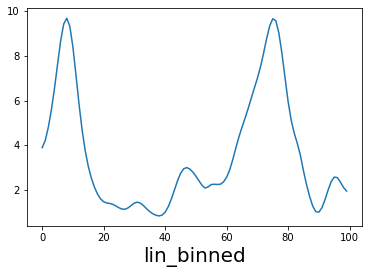

In [9]:
fr_map_dict[0].loc['unit_31'].plot()

In [10]:
import scipy
from scipy.stats import norm

In [31]:
def gm_func(xs_,ws,mus,sigmas,b):
    '''
    xs_: (P,) arguments to the gaussian mixture function
    mus, sigmas: (K,) parameters of the gaussians
    ws: (K,) weights
    b: bias/ baseline fr, scalar
    '''
    if len(xs_.shape)==1:
        xs = xs_[:,None] 
        assert xs.shape[1] == 1
    else:
        xs = xs_

    fs_all=norm.pdf(xs,loc=mus,scale=sigmas)
    assert fs_all.shape == (xs.shape[0],len(ws))

    fs=np.dot(fs_all,ws) + b
    return fs

def unwrap_pars(pars,return_dict=False,return_df=False):
    npars = len(pars)-1 # excluding b
    ws,mus,sigmas = pars[0:npars//3],pars[npars//3:(npars*2)//3],pars[(npars*2)//3:-1]
    b = pars[-1]
    if return_dict:
        return {'w':ws,'mu':mus,'sigma':sigmas,'b':b}
    elif return_df:
        cols = pd.MultiIndex.from_product([['w','mu','sigma'],np.arange(len(ws))+1])
        b_col=pd.MultiIndex.from_tuples([('b',1)])
        cols=cols.append(b_col)
        df = pd.DataFrame(pars,cols)
        return df
    return ws, mus, sigmas, b
    
def gm_func_wrapper(pars,xs):
    
#     ws,mus,sigmas = pars[0:npars//3],pars[npars//3:(npars*2)//3],pars[(npars*2)//3:-1]
#     b = pars[-1]
    ws,mus,sigmas,b = unwrap_pars(pars,return_dict=False,return_df=False)
    yhats=gm_func(xs,ws,mus,sigmas,b)
    return yhats
    
def gm_residual(pars,xs,ys):
#     npars = len(pars)
#     ws,mus,sigmas = pars[0:npars//3],pars[npars//3:(npars*2)//3],pars[(npars*2)//3:]
#     yhats=gm_func(xs_,ws,mus,sigmas)
    yhats = gm_func_wrapper(pars,xs)
    resid = ys - yhats
    return resid

def gm_func_multi_trials(xs,ws_l,mus_l,sigmas_l,b_l):
    
    pass


In [12]:
xs = np.arange(100)
ws = np.ones(2)
mus = np.zeros(len(ws))
sigmas = np.ones((len(ws)))
b = np.ones(1)*0
gm_func(xs,ws,mus,sigmas,b)
ys = fr_map_dict[0].loc['unit_31'].values

pars = np.concatenate([ws,mus,sigmas,b])
resid = gm_residual(pars,xs,ys)

In [67]:
ws_l = np.zeros((5,2))
mus_l = np.zeros((5,2))
sigmas_l = np.ones((5,2))
b_l = np.ones(5) * 0
xs_l = np.tile(xs[:,None],[1,5])


In [10]:
import jax
import jax.numpy as np
import jax.scipy as scipy

In [17]:
scipy.stats.norm

<module 'jax.scipy.stats.norm' from '/cm/shared/sw/nix/store/m6zzrz0yabsjkisw33bi1f8p5g3ryaxl-python-3.8.12-view/lib/python3.8/site-packages/jax/scipy/stats/norm.py'>

In [292]:
import numpy
from sklearn.gaussian_process.kernels import RBF
@jit
def gm_func_by_trial(xs,ws_l,mus_l,sigmas_l,b_l):
    '''
    ws/mus/sigmas_l: ntrial x Kfields
    b_l: ntrial,
    xs: np.arange(npos)
    ======
    fs: npos x ntrial 
    '''
    nt,K = ws_l.shape
    xs_l = np.tile(xs[:,None],[1,nt])
    fs_all_trial_one_field_l = []
    for k in range(K):
        fs_all_trial_one_field=scipy.stats.norm.pdf(xs_l,loc=mus_l[:,k],scale=sigmas_l[:,k])
        assert fs_all_trial_one_field.shape == (xs.shape[0],nt)
        fs_all_trial_one_field_l.append(fs_all_trial_one_field)
    fs_all_trial_one_field_l = np.array(fs_all_trial_one_field_l)
    fs_l = np.einsum('kpn,nk->pn',fs_all_trial_one_field_l,ws_l)

    fs_l_final = fs_l + b_l[None,:]
    return fs_l_final


def gm_func_by_trial_wrapper(xs,nt,pars):
    ws_l,mus_l,sigmas_l,b_l=unwrap_pars_by_trial(pars,nt)
    fs_l=gm_func_by_trial(xs,ws_l,mus_l,sigmas_l,b_l)
    return fs_l

def unwrap_pars_by_trial(pars,ntrials,return_dict=False,return_df=False):
    '''
    pars: order: ((field),partype),trial), such that after reshape, into ntrial x (nfield x npartype)
    
    '''
    pars_re = pars.reshape(ntrials,-1)
    npars = pars_re.shape[1]-1 # npars in one trial excluding b
    ws_l,mus_l,sigmas_l = pars_re[:,0:npars//3],pars_re[:,npars//3:(npars*2)//3],pars_re[:,(npars*2)//3:-1]
    K = ws_l.shape[1] # nfields
    b_l = pars_re[:,-1]
    if return_dict:
        return {'w':ws_l,'mu':mus_l,'sigma':sigmas_l,'b':b_l}
    elif return_df:
        cols = pd.MultiIndex.from_product([['w','mu','sigma'],np.arange(K)+1])
        b_col=pd.MultiIndex.from_tuples([('b',1)])
        cols=cols.append(b_col)
        df = pd.DataFrame(pars_re,columns=cols)
        return df
    return ws_l, mus_l, sigmas_l, b_l

def gm_residual_by_trial(pars_flat,ys_l):
    '''
    pars_flat
    ys_l: npos x ntrial 
    '''
    p,nt = ys_l.shape
    xs = np.arange(p)
    ws_l,mus_l,sigmas_l,b_l=unwrap_pars_by_trial(pars_flat,nt)
    fs_l=gm_func_by_trial(xs,ws_l,mus_l,sigmas_l,b_l)

    resid=ys_l-fs_l 
    return resid.flatten()

outer_minus = jit(vmap(vmap(np.subtract,in_axes=(None,1),out_axes=1),in_axes=(0,None),out_axes=0))
@jit
def gm_loss_by_trial(pars_flat,ys_l,kernel,lam):
    p,nt = ys_l.shape
    xs = np.arange(p)
    ws_l,mus_l,sigmas_l,b_l=unwrap_pars_by_trial(pars_flat,nt)
    fs_l=gm_func_by_trial(xs,ws_l,mus_l,sigmas_l,b_l)
    resid=ys_l-fs_l 
    l = 1/2*(resid**2).sum()
    
    @jit
    def regularization(mus_l):
        distance=outer_minus(mus_l,mus_l.T) # get nt x K x nt
        distance = np.linalg.norm(distance,axis=1) # nt x nt
        reg_cost= (distance * kernel).sum() * lam

        return reg_cost
    
    reg_cost = regularization(mus_l)


    return l+reg_cost

from sklearn.gaussian_process.kernels import RBF
def rbf_kernel(l,ntrials):
    '''
    l:length scale
    '''
    trials = np.arange(ntrials)[:,None]
    kernel=RBF(l)(trials,trials)
    return np.array(kernel)


In [248]:
kernel=rbf_kernel(5,21)

In [251]:
ind = 0
ch = 0
K=2
cell_name = cell_cols_dict['pyr'][ind]
fr_cell = fr_map_all_trials_dict[ch][ind]


ws_l = np.zeros((5,2))
mus_l = np.zeros((5,2))
sigmas_l = np.ones((5,2))
b_l = np.ones(5) * 0

pars=np.concatenate([ws_l,mus_l,sigmas_l,b_l[:,None]],axis=1)

# pars=unwrap_pars_by_trial(pars.flatten(),5,return_df=False)
# resid = gm_residual_by_trial(pars.flatten(),fr_cell[:,:5])
# l = gm_loss_by_trial(pars.flatten(),fr_cell[:,:5])
l = gm_loss_by_trial(pars.flatten(),fr_cell[:,:5],rbf_kernel(5,5),0.1)

In [254]:
l = gm_loss_by_trial(par.flatten(),fr_cell[:,:21],rbf_kernel(5,21),0.1)

In [255]:
l

(DeviceArray(3983.7756, dtype=float32), DeviceArray(1756.1548, dtype=float32))

In [293]:
# from scipy.optimize import least_squares
from scipy.signal import find_peaks

def init_one_trial(ys,K=2):
    peaks = np.array(find_peaks(ys,distance=20)[0])
    ind_in_peaks=np.flip(np.argsort(ys[peaks]))
#     import pdb
#     pdb.set_trace()
    init_locs = peaks[ind_in_peaks][:K]
    return init_locs

from jax import value_and_grad, grad, jit, vmap
def gd(func,par0,args,lr=0.1,niters=100):
    par_ = par0
    l_l = []
    for ii in range(niters):
        l,grad_val =value_and_grad(func,argnums=0)(par_,*args) 
        par_ =par_ - grad_val * lr
        l_l.append(l)
    return par_, np.array(l_l)

from jax.experimental import optimizers as jax_opt

def train_adam(func,par0,args,lr=0.1,niters=100):
    opt_init,opt_update,get_params=jax_opt.adam(lr)
    loss_l=[]
    @jit
    def train_step(step_i,opt_state):
        params=get_params(opt_state)
        loss,grads = value_and_grad(func,argnums=0)(params,*args) 
        import pdb
        pdb.set_trace()
        return loss, opt_update(step_i, grads, opt_state)
    opt_state=opt_init(par0)
    for ii in range(niters):
        loss,opt_state = train_step(ii,opt_state)
        loss_l.append(loss)
    return get_params(opt_state), np.array(loss_l)
    
    
def fit_all_trials(ys_l,K=2,doplot=False,fig=None,ax=None,niters=100,lr=0.01,length_scale=5,lam=0.1):
    

    p,nt = ys_l.shape
    init_locs_l=np.array([init_one_trial(np.array(ys)) for ys in ys_l.T]) # ntrials x K

    mu0 = init_locs_l
    sigma0 = np.ones_like(mu0)
    
    peak_y_l = ys_l[init_locs_l[:,0],np.arange(nt)]
    w0 =   np.dot((peak_y_l[:,None] / scipy.stats.norm.pdf(0,loc=0,scale=sigma0[0,0])), np.ones(K)[None,:])  
    b0 = np.ones(nt) * 0
    par0 = np.concatenate([w0,mu0,sigma0,b0[:,None]],axis=1)
    par0 = jax.lax.stop_gradient(par0.flatten())

    kernel = rbf_kernel(length_scale,nt)
    
#     res=least_squares(gm_residual_by_trial,par0,args=(ys_l,),method='lm')
#     res = scipy.optimize.minimize(gm_loss_by_trial,par0,args=(ys_l,),method='BFGS')
#     par =res.x
#     par,l_l=gd(gm_loss_by_trial,par0,(ys_l,),niters=100,lr=0.01)
    par,l_l=train_adam(gm_loss_by_trial,par0,(ys_l,kernel,lam),niters=niters,lr=lr)
    res=l_l
    par_dict = unwrap_pars_by_trial(par,nt,return_df=True)

    xs = np.arange(p)
    yhat=gm_func_by_trial_wrapper(xs,nt,par)
    plotreturn = None
    if doplot:
        if ax is None:
            fig,ax=plt.subplots(figsize=(4,2))
        ax.plot(ys)
        ax.plot(yhat)
        ax.legend(['ys','yhat'])
        plotreturn = (fig,ax)
    
    return par,par_dict,res,yhat,plotreturn


In [288]:
from jax.config import config
config.update('jax_disable_jit', True)

In [294]:
ys_l = np.array(fr_cell)
par,par_dict,res,yhat,plotreturn=fit_all_trials(ys_l,K=2,niters=1,lr=0.1,lam=0.1)

> /tmp/ipykernel_2110308/972395609.py(33)train_step()
     31         import pdb
     32         pdb.set_trace()
---> 33         return loss, opt_update(step_i, grads, opt_state)
     34     opt_state=opt_init(par0)
     35     for ii in range(niters):



ipdb>  grads


DeviceArray([-1.39768398e+00, -1.44871110e-02,             nan,
                         nan, -2.27770596e+01, -2.68884354e+01,
             -1.38523834e+02, -4.44386625e+00,  1.00526357e+00,
                         nan,             nan, -2.09163345e+02,
             -2.11340302e+02, -4.05612671e+02, -4.28602123e+00,
             -1.05202377e+00,             nan,             nan,
             -1.94283188e+02, -1.69436768e+02, -3.05688568e+02,
             -3.27961135e+00,  2.43983269e+00,             nan,
                         nan, -1.16147926e+02, -1.09783234e+02,
             -2.59805786e+02, -1.65533340e+00,  8.56536031e-01,
                         nan,             nan, -3.03310280e+01,
             -3.99945755e+01, -2.52191193e+02, -2.38821292e+00,
              1.86461020e+00,             nan,             nan,
             -5.95764465e+01, -6.04944077e+01, -2.13391388e+02,
             -2.76011753e+00, -5.18402100e-01,             nan,
                         nan, -8.2886444

ipdb>  loss


DeviceArray(21218.299, dtype=float32)


ipdb>  exit


BdbQuit: 

In [283]:
res[-100:]

DeviceArray([21218.303], dtype=float32)

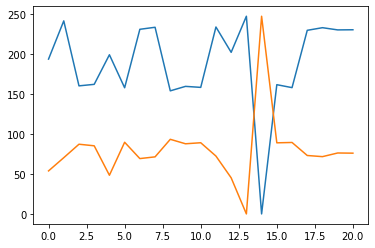

In [272]:
mus_l=np.array(par_dict['mu'].values)
plt.plot(np.linalg.norm(outer_minus(mus_l,mus_l.T),axis=1)[14])
plt.plot(np.linalg.norm(outer_minus(mus_l,mus_l.T),axis=1)[13])

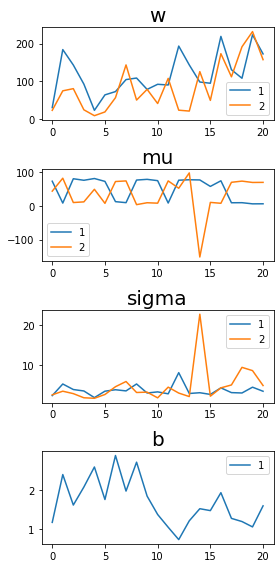

In [276]:
par_dict_all = par_dict
fig,ax=plt.subplots(4,1,figsize=(4,8))
par_names = par_dict_all.columns.get_level_values(level=0).unique()
for ii,pn in enumerate(par_names):
    par_dict_all[pn].plot(ax=ax[ii])
    ax[ii].set_title(pn)
plt.tight_layout()

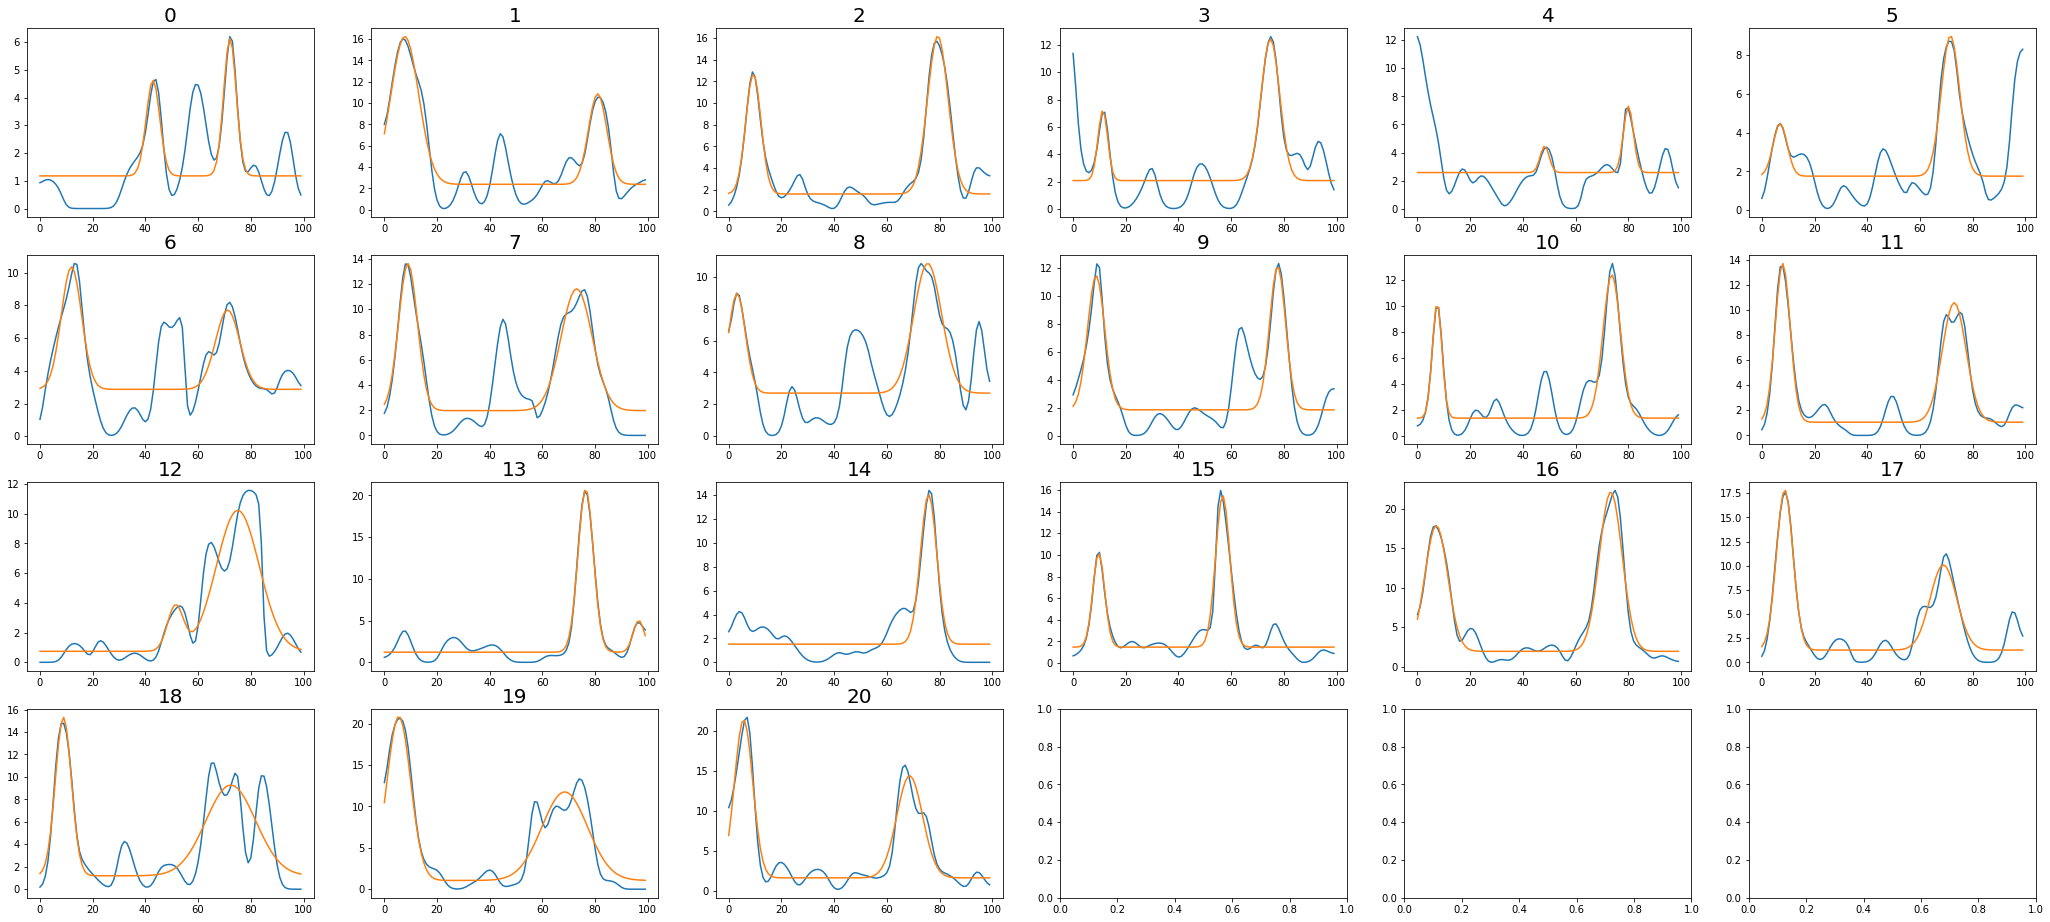

In [244]:
nplots = fr_cell.shape[-1]
fig,axs = ph.subplots_wrapper(nplots,return_axs=True)
p,nt = ys_l.shape
xs =np.arange(p)
fs_l = gm_func_by_trial_wrapper(xs,nt,par)
for ii,tr in enumerate(range(fr_cell.shape[-1])):
    
#     par,par_dict,res,yhat,(fig,ax) = fit_one_trial(ys,K=K,doplot=True,fig=fig,ax=axs.ravel()[ii])
    ax=axs.ravel()[ii]
    ax.plot(ys_l[:,tr],label='data')
    ax.plot(fs_l[:,tr],label='fit')
    ax.set_title(f'{tr}')
#     print(f'{tr}, success={res.success}')


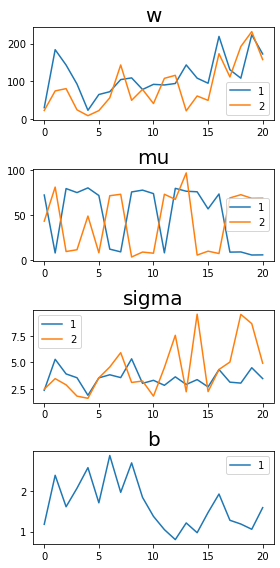

In [106]:
par_dict_all = par_dict
fig,ax=plt.subplots(4,1,figsize=(4,8))
par_names = par_dict_all.columns.get_level_values(level=0).unique()
for ii,pn in enumerate(par_names):
    par_dict_all[pn].plot(ax=ax[ii])
    ax[ii].set_title(pn)
plt.tight_layout()

In [13]:
ys = fr_map_dict[0].loc['unit_31'].values


In [181]:
from scipy.optimize import least_squares
from scipy.signal import find_peaks
def fit_one_trial(ys,K=2,doplot=False,fig=None,ax=None):
    xs = np.arange(len(ys))
    peaks = find_peaks(ys,distance=20)[0]
    ind_in_peaks=np.flip(np.argsort(ys[peaks]))
    init_locs = peaks[ind_in_peaks][:K]

    mu0 = init_locs
    sigma0 = np.ones(len(ws))
    w0 = np.ones(K) * (ys[init_locs[0]] / norm.pdf(0,loc=0,scale=sigma0[0]))
    b0 = np.ones(1) * 0
    par0 = np.concatenate([w0,mu0,sigma0,b0])

    res=least_squares(gm_residual,par0,args=(xs,ys),method='lm')
    par =res.x
    par_dict = unwrap_pars(par,return_df=True)

    yhat = gm_func_wrapper(par,xs)
    plotreturn = None
    if doplot:
        if ax is None:
            fig,ax=plt.subplots(figsize=(4,2))
        ax.plot(ys)
        ax.plot(yhat)
        ax.legend(['ys','yhat'])
        plotreturn = (fig,ax)
    
    return par,par_dict,res,yhat,plotreturn


0, success=True
1, success=True
2, success=True
3, success=True
4, success=True
5, success=True
6, success=True
7, success=True
8, success=True
9, success=True
10, success=True
11, success=True
12, success=True
13, success=True
14, success=True
15, success=True
16, success=True
17, success=True
18, success=True
19, success=True
20, success=True


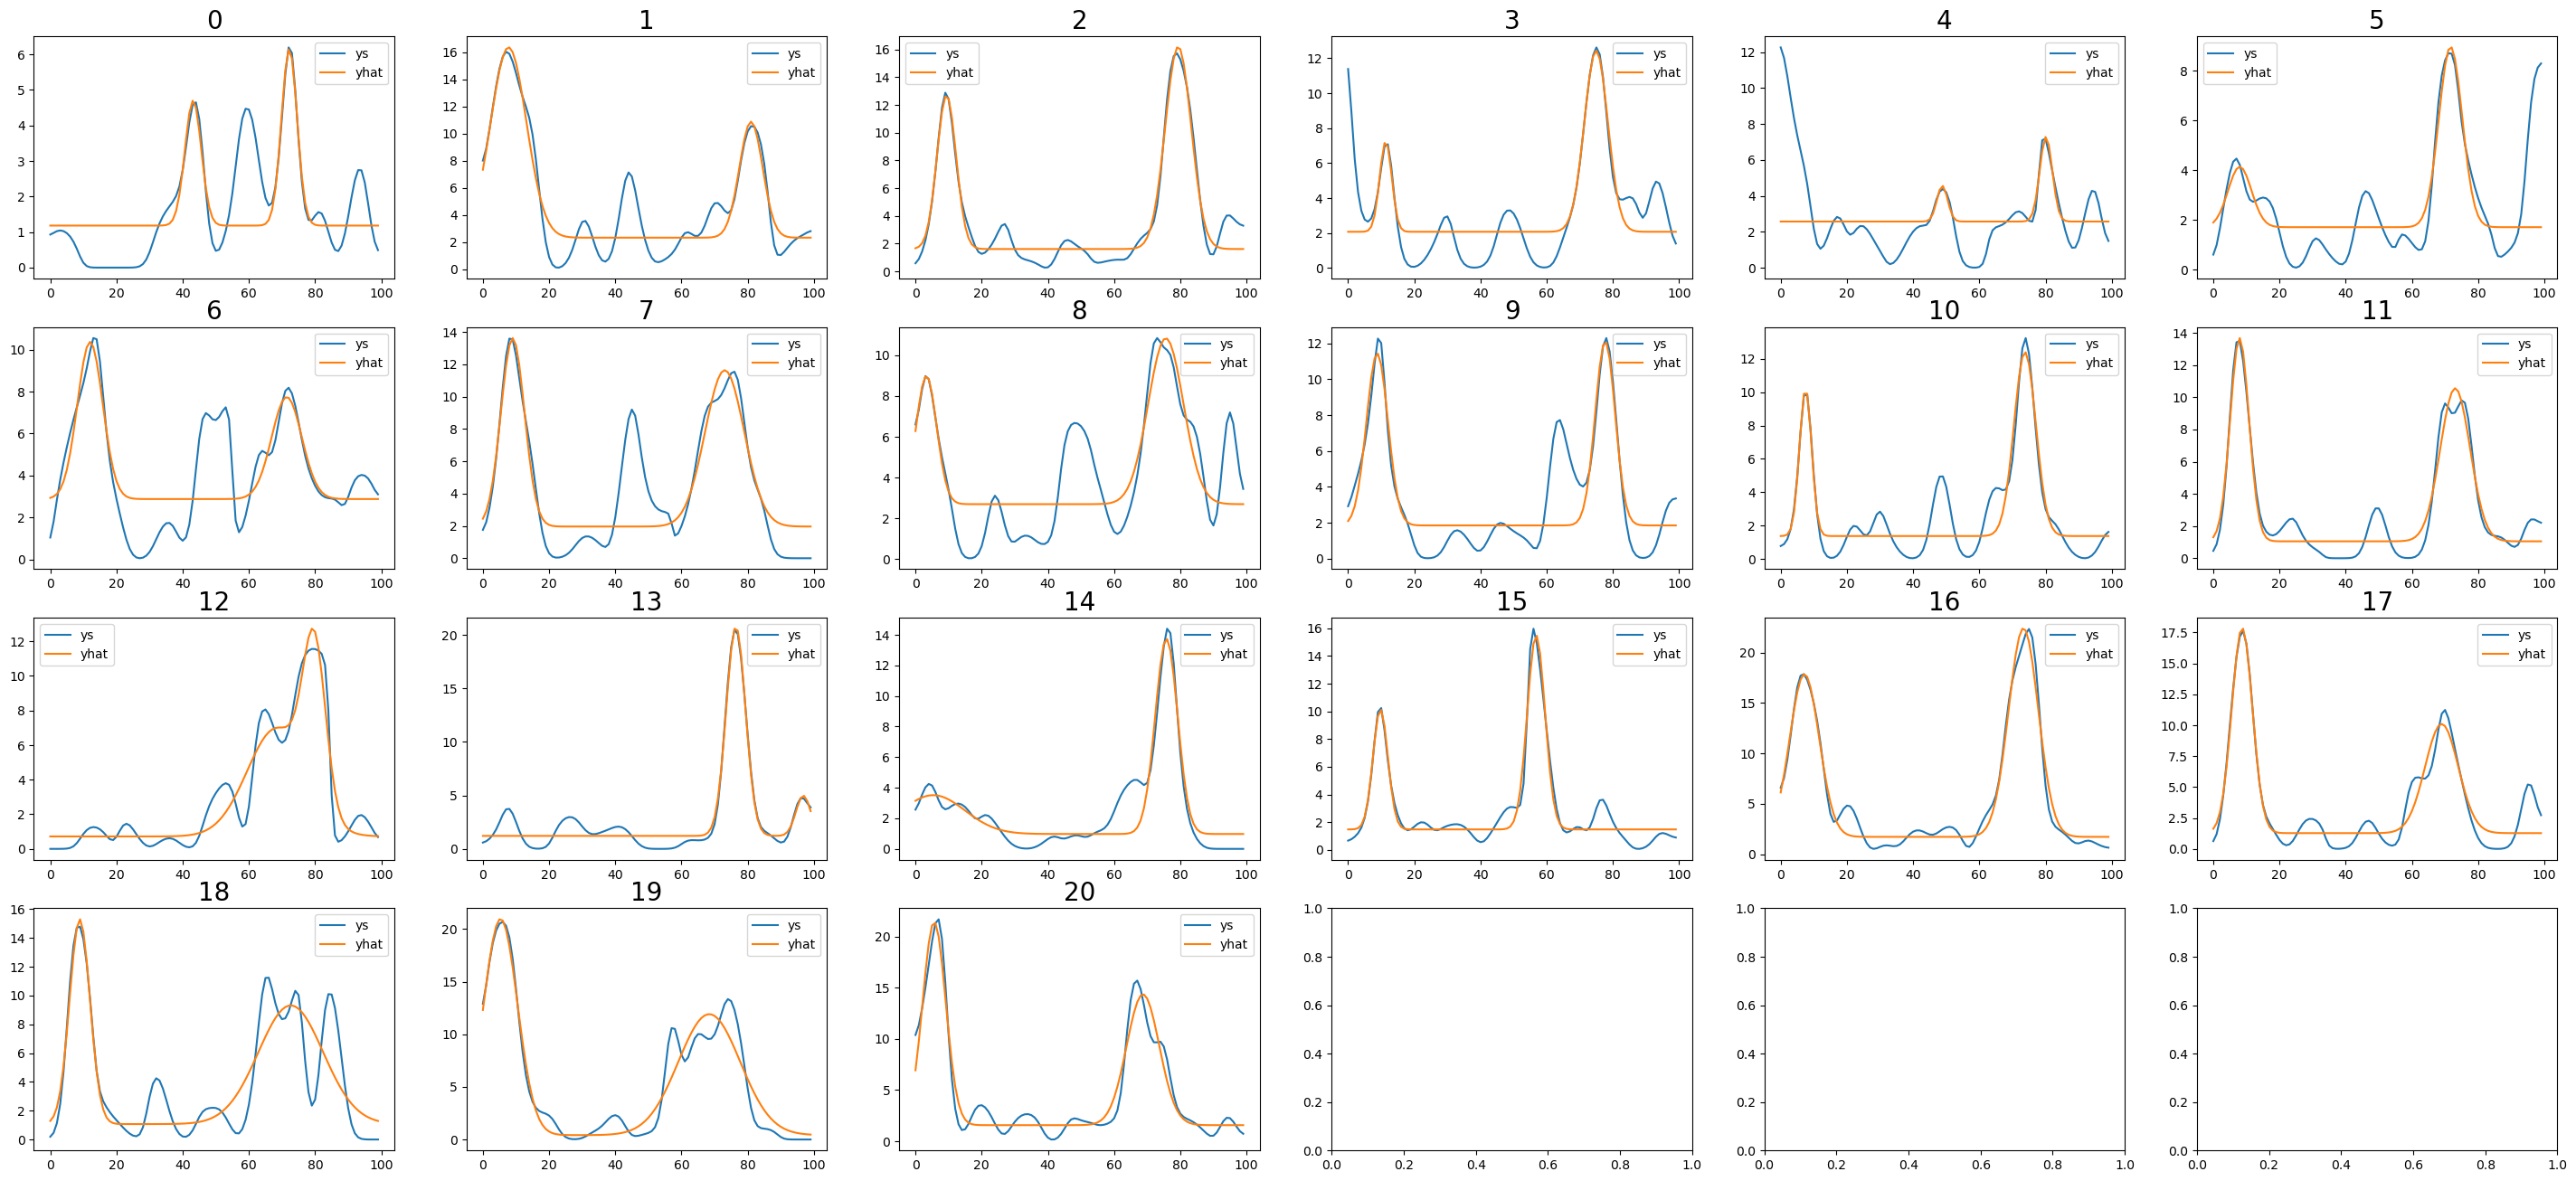

In [183]:
ind = 0
ch = 0
K=2
cell_name = cell_cols_dict['pyr'][ind]
fr_cell = fr_map_all_trials_dict[ch][ind]
par_dict_all = []
nplots = fr_cell.shape[-1]
fig,axs = ph.subplots_wrapper(nplots,return_axs=True)
for ii,tr in enumerate(range(fr_cell.shape[-1])):
    ys = fr_cell[:,tr]
    par,par_dict,res,yhat,(fig,ax) = fit_one_trial(ys,K=K,doplot=True,fig=fig,ax=axs.ravel()[ii])
    ax.set_title(f'{tr}')
    print(f'{tr}, success={res.success}')
    par_dict_all.append(par_dict)
par_dict_all = pd.concat(par_dict_all,axis=1).T.reset_index(drop=True)

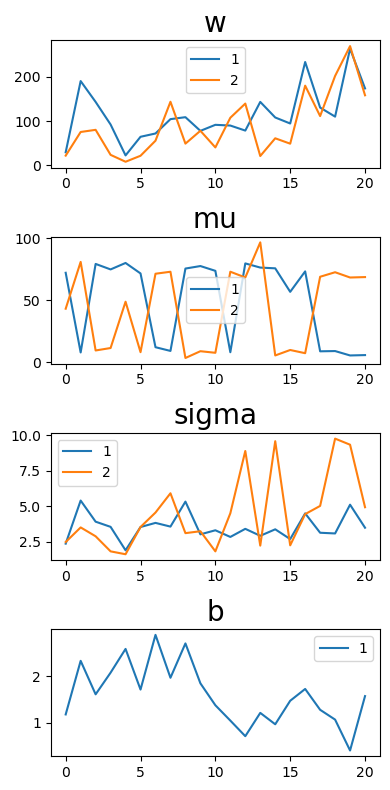

In [179]:
fig,ax=plt.subplots(4,1,figsize=(4,8))
par_names = par_dict_all.columns.get_level_values(level=0).unique()
for ii,pn in enumerate(par_names):
    par_dict_all[pn].plot(ax=ax[ii])
    ax[ii].set_title(pn)
plt.tight_layout()

In [143]:
par_dict_all_reshaped={k:np.stack([par_d[k] for par_d in par_dict_all],axis=0) for k in par_dict_all[0].keys()}

In [144]:
cols = pd.MultiIndex.from_product([['w','mu','sigma'],np.arange(K)+1])
b_col = pd.MultiIndex.from_tuples([('b',0)])
cols= cols.append(b_col)

pd.DataFrame(par_dict_all_reshaped,columns=cols)

Empty DataFrame
Columns: [(w, 1), (w, 2), (mu, 1), (mu, 2), (sigma, 1), (sigma, 2), (b, 0)]
Index: []

In [62]:
fr_map_all_trials_dict[0]

(333, 100, 21)

In [52]:
par,par_dict,res,yhat = fit_one_trial(xs,ys,K=2,doplot=False)

In [59]:
par_dict

{'w': array([ 77.77, 112.38]),
 'mu': array([ 7.58, 73.88]),
 'sigma': array([4.02, 6.05]),
 'b': 1.7371461243789705}

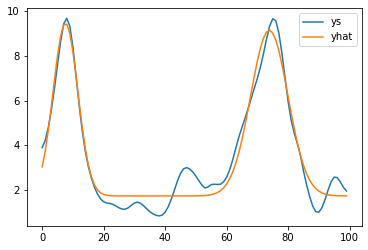

In [26]:
K = 2
peaks = find_peaks(ys,distance=20)[0]
ind_in_peaks=np.flip(np.argsort(ys[peaks]))
init_locs = peaks[ind_in_peaks][:K]

mu0 = init_locs
sigma0 = np.ones(len(ws))
w0 = np.ones(K) * (ys[init_locs[0]] / norm.pdf(0,loc=0,scale=sigma0[0]))
b0 = np.ones(1) * 0
par0 = np.concatenate([w0,mu0,sigma0,b0])

res=least_squares(gm_residual,par0,args=(xs,ys),method='lm')
par = res.x

yhat = gm_func_wrapper(par,xs)
plt.plot(ys)
plt.plot(yhat)
plt.legend(['ys','yhat'])

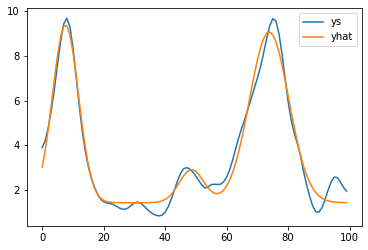

In [28]:
K = 3
peaks = find_peaks(ys,distance=20)[0]
ind_in_peaks=np.flip(np.argsort(ys[peaks]))
init_locs = peaks[ind_in_peaks][:K]

mu0 = init_locs
sigma0 = np.ones(K)
w0 = np.ones(K) * (ys[init_locs[0]] / norm.pdf(0,loc=0,scale=sigma0[0]))
b0 = np.ones(1) * 0
par0 = np.concatenate([w0,mu0,sigma0,b0])

res=least_squares(gm_residual,par0,args=(xs,ys),method='lm')
par = res.x

yhat = gm_func_wrapper(par,xs)
plt.plot(ys)
plt.plot(yhat)
plt.legend(['ys','yhat'])

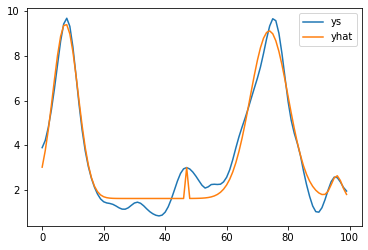

In [31]:
K = 4
peaks = find_peaks(ys,distance=20)[0]
ind_in_peaks=np.flip(np.argsort(ys[peaks]))
init_locs = peaks[ind_in_peaks][:K]

mu0 = init_locs
sigma0 = np.ones(K)
w0 = np.ones(K) * (ys[init_locs[0]] / norm.pdf(0,loc=0,scale=sigma0[0]))
b0 = np.ones(1) * 0
par0 = np.concatenate([w0,mu0,sigma0,b0])

res=least_squares(gm_residual,par0,args=(xs,ys),method='lm')
par = res.x

yhat = gm_func_wrapper(par,xs)
plt.plot(ys)
plt.plot(yhat)
plt.legend(['ys','yhat'])

In [34]:
np.set_printoptions(precision=2,suppress=True)
par

array([ 80.11, 115.97,   1.83,   4.34,   7.58,  73.85,  46.93,  95.81,
         4.09,   6.17,   0.03,   1.72,   1.62])